In [2]:
import pandas as pd
from scipy.stats import spearmanr

# Beispiel-Daten erstellen
data = {
    'wind_speed': [1, 2, 3, 4, 5],
    'temperature': [5, 6, 7, 8, 7],
    'pressure': [10, 9, 2, 4, 3],
    'production': []
}
df = pd.DataFrame(data)

# Spearman-Korrelationsmatrix berechnen
spearman_corr_matrix = df.corr(method='spearman')

print("Spearman-Korrelationsmatrix:")
print(spearman_corr_matrix)


ValueError: All arrays must be of the same length

In [ ]:
import pandas as pd

lat_min, lat_max = 35, 72
lon_min, lon_max = -25, 45

# Lade die Excel-Datei nur einmal, filtere die relevanten Daten und speichere sie als Parquet-Datei
WPP_file = "data/WPPs/Global-Wind-Power-Tracker-June-2024.xlsx"
df = pd.read_excel(WPP_file, sheet_name='Data')

# Filtere die Daten für Europa
df_filtered = df[(df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max) & (df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max)]

# Wähle nur die benötigten Spalten aus
df_filtered = df_filtered[['Latitude', 'Longitude', 'Capacity (MW)', 'Project Name', 'Status', 'Operator', 'Owner']]

# Speichere die gefilterten Daten im Parquet-Format (deutlich schneller zu lesen und schreiben, als Excel-Dateien, und auch platzsparender)
df_filtered.to_parquet("data/WPPs/Global-Wind-Power-Tracker-Europe.parquet")



wind speeds (COSMO-REA6)

In [2]:
import netCDF4 as nc

fn = r"C:\Users\alexa\Documents\Webapp\data\weather history\WS_100m.2D.199501.nc4" # January 1995
ds = nc.Dataset(fn)

print(ds)

time = ds.variables['time'][:]
lon = ds.variables['RLON'][:]
lat = ds.variables['RLAT'][:]
wind_speed = ds.variables['wind_speed'][:]

for i in range(len(lon)):
    for j in range(len(lon[0])):
        lon[i,j] = lon[i,j] - 360 if lon[i,j] > 180 else lon[i,j]
    

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/cdi)
    source: model: cosmo_de, status: unknown, version: not available, generating_process: analysis, product_category: determinist
    institution: Deutscher Wetterdienst
    Conventions: CF-1.6
    ConventionsURL: http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.pdf
    NCO: "4.6.2"
    nco_openmp_thread_number: 1
    CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
    history: Thu Aug 23 06:26:28 UTC 2018: COSMO-REA6 wind speed at 100m calculated with FIELDEXTRA v12.7 from U and V
    dimensions(sizes): time(744), rlon(848), rlat(824)
    variables(dimensions): float64 time(time), float32 RLON(rlat, rlon), float32 RLAT(rlat, rlon), float32 rlon(rlon), float32 rlat(rlat), float32 wind_speed(time, rlat, rlon)
    groups: 


three different visualisations

(824, 848) (824, 848) (744, 824, 848)


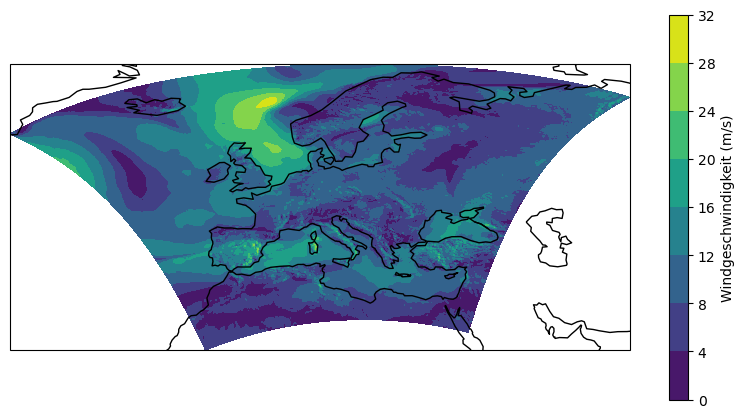

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Erstelle eine Karte mit cartopy
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Trage die Windgeschwindigkeit auf der Karte ein
plt.contourf(lon, lat, wind_speed[0,:,:], transform=ccrs.PlateCarree(), cmap='viridis')

# Füge Küstenlinien hinzu
ax.coastlines()

# Zeige die Karte
plt.colorbar(label="Windgeschwindigkeit (m/s)")
plt.show()


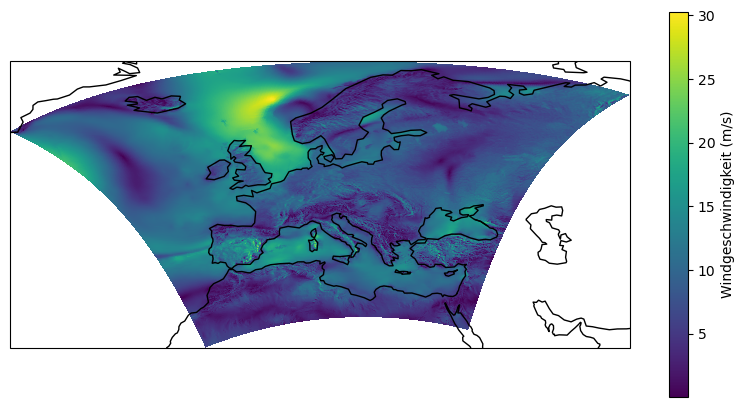

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Erstelle eine Karte mit curvilinearen Daten
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Zeichne die Windgeschwindigkeit auf dem curvilinearen Gitter
plt.pcolormesh(lon, lat, wind_speed[0,:,:], transform=ccrs.PlateCarree(), cmap='viridis')

# Füge Küstenlinien hinzu
ax.coastlines()

# Zeige die Karte
plt.colorbar(label="Windgeschwindigkeit (m/s)")
plt.show()


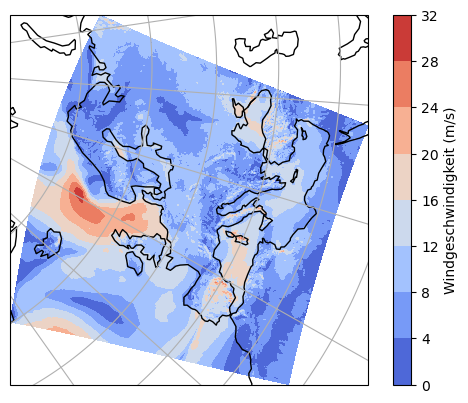

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Verwende eine Lambert-Projektion
ax = plt.axes(projection=ccrs.LambertConformal())

# Zeichne die Windgeschwindigkeit auf dem curvilinearen Gitter
plt.contourf(lon, lat, wind_speed[0,:,:], transform=ccrs.PlateCarree(), cmap='coolwarm')

# Küstenlinien und Raster hinzufügen
ax.coastlines()
ax.gridlines()

plt.colorbar(label="Windgeschwindigkeit (m/s)")
plt.show()


power curve

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Definiere die Power Curve (Windgeschwindigkeit und Leistung)
wind_speeds = np.arange(0, 25.5, 0.5)  # Windgeschwindigkeiten
power_output = [0]*7 + [35, 80, 155, 238, 350, 474, 630, 802, 1018, 1234, 1504, 1773, 2076, 2379, 2664, 2948, 3141, 3334, 3425, 3515, 3546, 3577, 3586, 3594, 3598, 3599] + [3600]*18  # Leistung
max_cap = 3600
power_output_norm = [x / max_cap for x in power_output]
wind_speed_max = 25

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(wind_speeds, power_output_norm, kind='cubic', fill_value="extrapolate")

# Beispiel für Interpolation: Bestimme Werte für feinere Windgeschwindigkeiten
fine_wind_speeds = np.linspace(0, 25, 100)  # Feinere Windgeschwindigkeiten
interpolated_power_output = interpolation_function(fine_wind_speeds)

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(wind_speeds, power_output_norm, 'o', label='Diskrete Werte')  # Diskrete Punkte
plt.plot(fine_wind_speeds, interpolated_power_output, '-', label='Interpolierte Werte')  # Interpolierte Werte
plt.xlabel('Windgeschwindigkeit (m/s)')
plt.ylabel('Leistung (kW)')
plt.title('Interpolierte Power Curve')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import pandas as pd

# Datei laden (relativer Pfad)
file_path = "./Global-Wind-Power-Tracker-June-2024.xlsx"
df = pd.read_excel(file_path, sheet_name='Data')

# Bereich für Europa definieren
lat_min, lat_max = 35, 72
lon_min, lon_max = -25, 45

# Filtere die Daten für den geografischen Bereich in Europa
df_filtered = df[(df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max) & 
                 (df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max)]

FileNotFoundError: [Errno 2] No such file or directory: './Global-Wind-Power-Tracker-June-2024.xlsx'

WPPs capacity distribution

In [ ]:
import matplotlib.pyplot as plt

# Verteilung der Kapazität berechnen
capacity_distribution = df_filtered['Capacity (MW)'].value_counts()

# Diagramm erstellen, nur bis zum Maximalwert
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['Capacity (MW)'].dropna(), bins=1000, range=(0, 2000), edgecolor='black')
plt.title('Verteilung der Windkraftanlagenkapazitäten in Europa')
plt.xlabel('Kapazität (MW)')
plt.ylabel('Anzahl')
plt.grid(True)
plt.show()

visualisation of WPPs

In [ ]:
from ipyleaflet import Map, Marker, MarkerCluster
from ipywidgets import Layout

# Erstelle die Karte
m = Map(center=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2],
        zoom=5,
        layout=Layout(width='100%', height='500px')
       )

# Erstelle Marker-Objekte für jede Windkraftanlage
markers = [Marker(location=(row['Latitude'], row['Longitude'])) for _, row in df_filtered.iterrows()]

# Erstelle einen Marker Cluster
marker_cluster = MarkerCluster(markers=markers, disable_clustering_at_zoom=18)

# Füge den Marker Cluster zur Karte hinzu
m.add_layer(marker_cluster)

# Zeige die Karte an
m

data generation with power curve

In [ ]:
import numpy as np

# Masked array in ein reguläres Array umwandeln
wind_speed_array = np.ma.filled(wind_speed[0,:,:], np.nan)

# Verteilung der Kapazitäten aus 'Capacity (MW)'
capacity_distribution = df_filtered['Capacity (MW)'].dropna().values

# Häufigkeiten der Kapazitäten berechnen
unique_capacities, counts = np.unique(capacity_distribution, return_counts=True)

# Wahrscheinlichkeiten für jede Kapazität (relative Häufigkeit)
probabilities = counts / counts.sum()

# Initialisiere die np.array Strukturen für die Daten
data = np.zeros((3, wind_speed_array.size))  # 3 Reihen für wind_speed, capacity, production

# Skaliere die Produktion basierend auf der Verteilung mit gewichteter Auswahl
for i in range(wind_speed_array.shape[0]):
    for j in range(wind_speed_array.shape[1]):
        wind_speed_select = wind_speed_array[i, j] # Verwende alle Windgeschwindigkeiten von Januar 1995
        capacity = np.random.choice(unique_capacities, p=probabilities) # Wähle eine Kapazität basierend auf ihrer Wahrscheinlichkeit
        production = interpolation_function(wind_speed_select) * capacity
        production = production if wind_speed_select < wind_speed_max else 0
                
        # Fülle die Werte in das np.array
        data[0, i*wind_speed_array.shape[0]+j] = wind_speed_select  # Windgeschwindigkeit
        data[1, i*wind_speed_array.shape[0]+j] = capacity  # Kapazität
        data[2, i*wind_speed_array.shape[0]+j] = production # Produktion


ANN with PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Verwende dein generiertes numpy Array mit Wind Speed, Capacity und Scaled Production
# data[0, :] -> Windgeschwindigkeit
# data[1, :] -> Kapazität
# data[2, :] -> Skalierte Produktion

X = data[:2, :].T  # Features: Erste zwei Reihen, transponiert zu (Anzahl der Datenpunkte, 2)
y = data[2, :]  # Target: Dritte Reihe (scaled production)

# Normalisierung der Features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Normiere Windgeschwindigkeit und Kapazität auf Standardnormalverteilung

# Train/Test Split (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konvertiere die Numpy Arrays in PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Output Tensor (2D, mit shape [N, 1])
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Erstellen des ANN-Modells
class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        # Input Layer: 2 Features (Wind Speed und Capacity)
        # Hidden Layer 1: 64 Neuronen
        # Hidden Layer 2: 32 Neuronen
        # Output Layer: 1 (Scaled Production)
        self.fc1 = nn.Linear(2, 64)  # Eingabe: 2 Features
        self.fc2 = nn.Linear(64, 32)  # Erste versteckte Schicht
        self.fc3 = nn.Linear(32, 1)  # Ausgabe: 1 Wert (Scaled Production)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialisiere das Modell, den Optimizer und die Loss-Funktion
model = ANN_Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error für Regression

# Training des Modells
epochs = 500
losses = []

for epoch in range(epochs):
    model.train()
    
    # Vorwärtsdurchlauf
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Rückwärtsdurchlauf und Optimierung
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Speichern des Verlusts
    losses.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotte den Trainingsverlust
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Teste das Modell
model.eval()
with torch.no_grad(): # don't calculate gradient: model remains tel quel during testing
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Forecast auf Basis hypothetischer Werte (z.B. hypothetische Wind Speed und Capacity)
hypothetical_data = np.array([[12, 1500], [8, 3000], [20, 500]])  # Beispielwerte: [Wind Speed, Capacity]
hypothetical_tensor = torch.tensor(hypothetical_data, dtype=torch.float32)

# Vorhersagen machen
with torch.no_grad(): # don't calculate gradient: model remains tel quel during forecasting
    forecasted_production = model(hypothetical_tensor)
    print(f'Hypothetische Vorhersagen (Wind Speed, Capacity -> Scaled Production): {forecasted_production}')


ANN with tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Beispiel-Daten (Windgeschwindigkeit, Kapazität, Produktion)
# Nehmen wir an, 'data' ist ein Vektor mit drei Listen:
wind_speed = data[0]  # Erste Zeile: Windgeschwindigkeiten
capacity_mw = data[1]  # Zweite Zeile: Kapazität (MW)
scaled_production = data[2]  # Dritte Zeile: Produktion (Scaled Production)

# Eingabedaten als Feature-Array
X = np.column_stack((wind_speed, capacity_mw))

# Zielwert (Scaled Production)
y = scaled_production

# Daten aufteilen in Trainings- und Testdatensatz (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren (wichtig für ein stabiles Training)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Erstelle das Modell (ANN)
model = Sequential()

# Eingabeschicht und erste verborgene Schicht (mit 64 Neuronen und ReLU-Aktivierungsfunktion)
model.add(Dense(64, input_dim=2, activation='relu'))

# Zweite verborgene Schicht
model.add(Dense(64, activation='relu'))

# Ausgabeschicht (1 Neuron für die Vorhersage der Produktion)
model.add(Dense(1, activation='linear'))

# Kompiliere das Modell mit Adam Optimizer und Mean Squared Error als Verlustfunktion
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Trainiere das Modell auf den Trainingsdaten
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluierung des Modells auf den Testdaten
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss (Mean Squared Error): {loss}')

# Vorhersage auf neuen hypothetischen Daten (z.B. Kapazität=4.5 MW, Windgeschwindigkeit=15 m/s)
hypothetical_data = np.array([[15, 4.5]])
hypothetical_data_scaled = scaler.transform(hypothetical_data)
predicted_production = model.predict(hypothetical_data_scaled)

print(f'Hypothetische Vorhersage der Produktion: {predicted_production[0][0]}')

# Vorhersage auf den Testdaten (zum Vergleich)
predictions = model.predict(X_test_scaled)
